### imports

In [1]:
from neuralmonkey.classes.session import load_mult_session_helper
from pythonlib.tools.stroketools import strokesInterpolate2
import pythonlib
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
import random
import math
import os
import pandas as pd

In [2]:
%load_ext autoreload
%autoreload 2

### Session helper functions

In [3]:
################################################
### Extracting a Session's successful Trialcodes/Trialnums ###
################################################

# get a list of successful trialcodes
def getSuccessfulTrialCodes(sn):
    D = sn.Datasetbeh
    Dcopy = D.copy()
    Dcopy.preprocessGood(params=["one_to_one_beh_task_strokes"]) # prunes Dcopy to keep only successful trials
    
    return Dcopy.Dat['trialcode'].tolist()

def getAllTrialCodes(sn):
    return sn.Datasetbeh.Dat['trialcode'].tolist()

# from the list of trialcodes, get matching list of NEURAL trials
def getNeuralTrialNumsFromTrialCodes(sn, trialcode_list):
    D = sn.Datasetbeh
    trials = []
    for tc in trialcode_list:
        # make sure there is exactly one matching trialcode
        #index_dataset = D.Dat[(D.Dat["trialcode"]==tc)].index
        #assert len(index_dataset)==1

        # pull out these datapoints from trial-level dataset
        t = sn.datasetbeh_trialcode_to_trial(tc)
        trials.append(t)
        #ons, offs = sn.strokes_extract_ons_offs(trialtdt)
    return trials

# get a list of successful trialnums
def getSuccessfulNeuralTrialNums(sn):
    trialcodes = getSuccessfulTrialCodes(sn)
    return getNeuralTrialNumsFromTrialCodes(sn, trialcodes)

def getAllNeuralTrialNums(sn):
    return getNeuralTrialNumsFromTrialCodes(sn, getAllTrialCodes(sn))
    


################################################
### Extracting/Plotting Eye-Tracking Data ###
################################################

# returns smoothed and transformed x,y data for a session/trialnum
def getEyeXYSmoothedAndTransformed(sn, trialnum, PLOT=True):
    # get TRANSFORMED xy-coordinates (used calibration matrix to map to screen)
    st = sn.beh_extract_eye_good(trialnum)
    times = st[0]
    x_aff = st[1][:,0]
    y_aff = st[1][:,1]

    # SMOOTH DATA
    from pythonlib.tools.timeseriestools import smoothDat
    x_aff_sm = smoothDat(x_aff, window_len=10)
    y_aff_sm = smoothDat(y_aff, window_len=10)
    
    if PLOT==True:
        fig, axes = plt.subplots(2,1, figsize=(10, 10))
        # plot smoothed x-data
        axes[0].plot(times,x_aff_sm)
        # plot smoothed y-data
        axes[1].plot(times,y_aff_sm)
        return x_aff_sm, y_aff_sm, times, axes
    else:
        return x_aff_sm, y_aff_sm, times

# plot the (x,y) data over time for eye tracking data
def plotEyeTrackingTrace(times, x_vals, y_vals, ax, color="b"):
    ax.plot(x_vals, y_vals, "-k", alpha=0.3)
    ax.scatter(x_vals, y_vals, c=times, alpha=0.5, marker="o")   
    

# get the start, end times for the window spanned by start_event, end_event
def getTimeWindowOfEvents(sn, trial, start_event, end_event):
    # keep just times between [start_event, end_event]
    dict_event_times = sn.events_get_time_sorted(trial, list_events=(start_event, end_event))[0]
    start_time = dict_event_times[start_event][0]
    end_time = dict_event_times[end_event][0]
    
    return start_time, end_time


# return mask array of whether within bounding box
def getBoundingBoxMask(x, y, minx, miny, maxx, maxy):
    assert len(x) == len(y), "xy must be same length"
    xn = np.array(x)
    yn = np.array(y)

    result = ((xn >= minx) & (xn <= maxx) & (yn >= miny) & (yn <= maxy))
    #print(result)
    return result

## Part 1: export x,y,times,outlier_mask to MATLAB

In [23]:
## LOAD IN SESSION ##

date = 230628
animal = "Diego"
session = 0
basedir = "/home/kgg/Desktop/eyetracking_analyses/"

Searching using this string:
/home/kgg/mnt/Freiwald/ltian/recordings/*Diego*/*230628*/**
Found this many paths:
1
---
/home/kgg/mnt/Freiwald/ltian/recordings/Diego/230628/Diego-230628-144138
session:  0
Beh Sessions that exist on this date:  {230628: [(1, 'primsingridfixed6cDiego')]}
------------------------------
Loading this neural session: 0
Loading these beh expts: ['primsingridfixed6cDiego']
Loading these beh sessions: [1]
Using this beh_trial_map_list: [(1, 0)]
Searching using this string:
/home/kgg/mnt/Freiwald/ltian/recordings/*Diego*/*230628*/**
Found this many paths:
1
---
/home/kgg/mnt/Freiwald/ltian/recordings/Diego/230628/Diego-230628-144138
{'filename_components_hyphened': ['Diego', '230628', '144138'], 'basedirs': ['/home/kgg/mnt/Freiwald/ltian/recordings/Diego', '/home/kgg/mnt/Freiwald/ltian/recordings/Diego/230628'], 'basedirs_filenames': ['230628', 'Diego-230628-144138'], 'filename_final_ext': 'Diego-230628-144138', 'filename_final_noext': 'Diego-230628-144138'}
FOund

ADded new column: supervision_online
Appended self.Dat[superv_SEQUENCE_SUP]
Appended self.Dat[superv_SEQUENCE_ALPHA]
Appended self.Dat[superv_COLOR_ON]
Appended self.Dat[superv_COLOR_ITEMS_FADE_TO_DEFAULT_BINSTR]
Appended self.Dat[superv_COLOR_METHOD]
Appended self.Dat[superv_GUIDEDYN_ON]
Appended self.Dat[superv_VISUALFB_METH]
appended col to self.Dat:
supervision_stage_new
Appended self.Dat[superv_SEQUENCE_SUP]
Appended self.Dat[superv_COLOR_ON]
Appended self.Dat[superv_COLOR_METHOD]
Appended self.Dat[superv_COLOR_ITEMS_FADE_TO_DEFAULT_BINSTR]
Appended self.Dat[superv_GUIDEDYN_ON]
appended col to self.Dat:
supervision_stage_concise
Append column to self.Dat:  supervision_stage_semantic
Extracted into self.Dat[epoch_orig]
Modified self.Dat[epoch]
837
- starting/ending len (getting sequence):
837
837
--- Removing nans
start len: 837
- num names for each col
not removing nans, since columns=[]
Reassigned train/test, using key: probe
and values:
Train =  [0]
Test =  [1]
 
New distributio

1233
1234
1235
1236
1237
1238
1239
1240
1241
1242
1243
1244
1245
1246
1247
1248
1249
1250
1251
1252
1253
1254
1255
1256
1257
1258
1259
1260
1261
1262
1263
1264
1265
1266
1267
1268
1269
1270
1271
1272
1273
1274
1275
1276
1277
1278
1279
1280
1281
1282
1283
1284
1285
1286
1287
1288
1289
1290
1291
1292
1293
1294
1295
1296
1297
1298
1299
1300
1301
1302
1303
1304
1305
1306
1307
1308
1309
1310
1311
1312
1313
1314
1315
1316
1317
1318
1319
1320
1321
1322
1323
1324
1325
1326
1327
1328
1329
1330
1331
1332
1333
1334
1335
1336
1337
1338
1339
1340
1341
1342
1343
1344
1345
1346
1347
1348
1349
1350
1351
1352
1353
1354
1355
1356
1357
1358
1359
1360
1361
1362
1363
1364
1365
1366
1367
1368
1369
1370
1371
1372
1373
1374
1375
1376
1377
1378
1379
1380
1381
1382
1383
1384
1385
1386
1387
1388
1389
1390
1391
1392
1393
1394
1395
1396
1397
1398
1399
1400
1401
1402
1403
1404
1405
1406
1407
1408
1409
1410
1411
1412
1413
1414
1415
1416
1417
1418
1419
1420
1421
1422
1423
1424
1425
1426
1427
1428
1429
1430
1431
1432


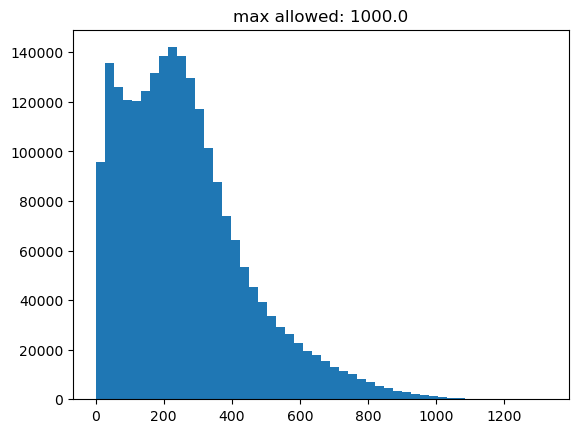

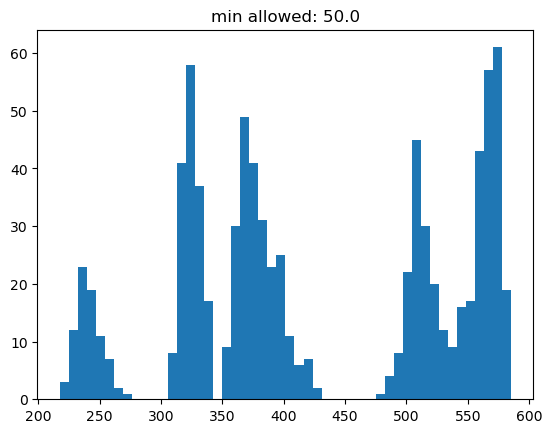

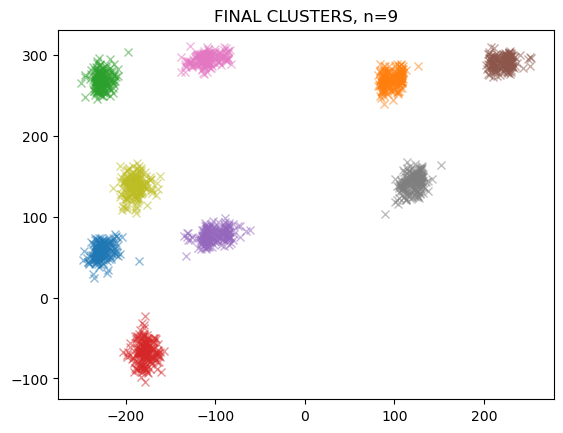

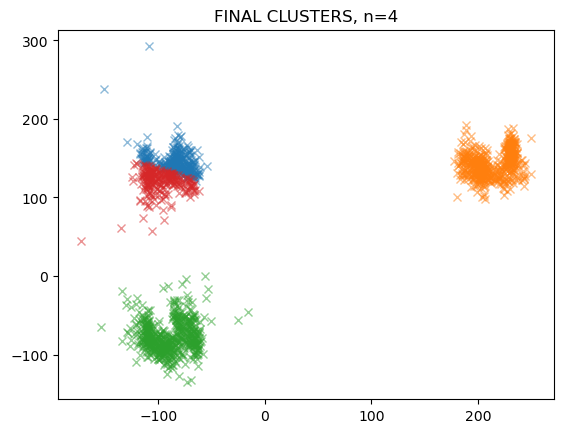

In [24]:
# change to base dir
os.chdir(basedir)

# mkdir for animal-date-session
dirn = animal + "-" + str(date) + "-" + str(session)
os.makedirs(dirn, exist_ok=True)
os.chdir(dirn)

# load session
#MS = load_mult_session_helper(date, animal)
MS = load_mult_session_helper(date, animal, MINIMAL_LOADING=True, spikes_version="kilosort")
sn = MS.SessionsList[session]

#success_neural_trials = getSuccessfulNeuralTrialNums(sn)
all_neural_trials = getAllNeuralTrialNums(sn)
# store valid trialnums
neuraltnums = []
tcodes = []

SAVEMATS=False

# get bounding box
# - format: [[-x, -y], [+x, +y]]. does not save in self
#bounding_box = sn.Datasetbeh.recomputeSketchpadEdgesAll(strokes_ver="strokes_task")
#print(bounding_box)


# loop thru trials and save xy data
for ntrial in all_neural_trials:
    if SAVEMATS==True:
        # get sampling rate
        t,v,fs_raw = sn.extract_data_tank_streams("eyex", ntrial, ploton=False)

        # get XY smoothed / transformed on eye calibration matrix
        x_raw,y_raw,times_raw = getEyeXYSmoothedAndTransformed(sn, ntrial, False)

        # resample x, y, times using integer sampling rate
        fs_new = 200
        stroke_raw = [np.array([x_raw, y_raw, times_raw]).T] # dummy stroke list
        stroke_intp = strokesInterpolate2(stroke_raw, ["fsnew", fs_new, fs_raw])
        stroke_resampled = stroke_intp[0]
        x_rs = stroke_resampled[:,0]
        y_rs = stroke_resampled[:,1]
        times_rs = stroke_resampled[:,2]

        # save data to be loaded into MATLAB
        fname = "ntrial" + str(ntrial) + ".mat"
        scipy.io.savemat(fname, dict(x=x_rs, y=y_rs, times=times_rs, fs_hz=fs_new))

    # save neuraltnums, tcodes
    neuraltnums.append(ntrial)
    tcodes.append(sn.datasetbeh_trial_to_trialcode(ntrial))

# save trial numbers for later use in MATLAB
scipy.io.savemat("all_ntrialnums.mat", dict(neuraltrialnums=neuraltnums))

# save trialcodes for later use in MATLAB
scipy.io.savemat("all_trialcodes.mat", dict(trialcodes=tcodes))

# Part 2: run dates in MATLAB clusterfix

In [4]:
# (do in matlab)

# Part 3: reload in fixation/saccade times and save to .csv 

In [25]:
# change to base dir
os.chdir(basedir)

# change to animal-date-session
dirn = animal + "-" + str(date) + "-" + str(session)
os.chdir(dirn)

# load in results
mat = scipy.io.loadmat('clusterfix_results.mat')

# add results to dataframe

mat_vars = ['neuraltrialnum', 'trialcode', 'fs', 'x', 'y', 'times', 'fixation_start_inds',
            'fixation_end_inds', 'fixation_centroids_x', 'fixation_centroids_y', 
            'saccade_start_inds', 'saccade_end_inds']
tmp = []
for i in range(len(mat['RESULTS'][0])):
    neuraltrialnum = mat['RESULTS'][0]['neuraltrialnum'][i][0,0]
    tcode = mat['RESULTS'][0]['trialcode'][i][0]
    fs = mat['RESULTS'][0]['fs'][i][0,0]
    x = mat['RESULTS'][0]['x'][i][0]
    y = mat['RESULTS'][0]['y'][i][0]
    times = mat['RESULTS'][0]['times'][i][0]

    # get start, end inds for fixations/saccades
    fixation_start_inds = mat['RESULTS'][0]['fixation_inds'][i][0]
    fixation_end_inds = mat['RESULTS'][0]['fixation_inds'][i][1]
    saccade_start_inds = mat['RESULTS'][0]['saccade_inds'][i][0]
    saccade_end_inds = mat['RESULTS'][0]['saccade_inds'][i][1]

    # get centroids x,y
    fixation_centroids_x = mat['RESULTS'][0]['fixation_centroids'][i][0]
    fixation_centroids_y = mat['RESULTS'][0]['fixation_centroids'][i][1]

    dat = [neuraltrialnum, tcode, fs, x, y, times, fixation_start_inds, fixation_end_inds,
            fixation_centroids_x, fixation_centroids_y, saccade_start_inds, saccade_end_inds]
    tmp.append({})
    for v, d in zip(mat_vars, dat):
        tmp[-1][v]=d

clusterfix_results = pd.DataFrame(tmp, columns=mat_vars)

### save saccade, fixation onsets/offsets into .csv to be loaded by neuralmonkey/session.py

from numpy import savetxt

#for i in range(len(neuraltnums)):
for index, row in clusterfix_results.iterrows():
    tnum = row['neuraltrialnum']
    print("tnum", tnum)
    tcode = row['trialcode']
    print("tcode", tcode)

    x_t = row['x']
    y_t = row['y']
    times_t = row['times']

    # get the FIXATIONS belonging to this trial
    fixation_start_inds = row['fixation_start_inds']
    fixation_end_inds = row['fixation_end_inds']
    fixation_centroids_x = row['fixation_centroids_x']
    fixation_centroids_y = row['fixation_centroids_y']
    centroid_pairs = [[x,y] for x,y in zip(fixation_centroids_x, fixation_centroids_y)]

    # get the times of the FIXATIONS
    fixation_start_times = times_t[fixation_start_inds]
    fixation_end_times = times_t[fixation_end_inds]
    print("fixation start times", fixation_start_times)
    print("fixation end times", fixation_end_times)

    # TODO: remove any fixations that contain outlier times... (must compute bounding box)

    # save fixation start times using TRIALCODE, to load into session.py
    fname = f"{tcode}-fixation-onsets.csv"
    savetxt(fname, fixation_start_times, delimiter=',')

    # save fixation centroids using TRIALCODE, to load into session.py
    fname = f"{tcode}-fixation-centroids.csv"
    savetxt(fname, centroid_pairs, delimiter=",")

    # get the times of the SACCADES
    saccade_start_inds = row['saccade_start_inds']
    saccade_end_inds = row['saccade_end_inds']
    saccade_start_times = times_t[saccade_start_inds]
    saccade_end_times = times_t[saccade_end_inds]

    print("saccade start times", saccade_start_times)
    print("saccade end times", saccade_end_times)

    # TODO: remove any saccades that contain outlier times

    # save saccade start times using TRIALCODE, to load into session.py
    fname = f"{tcode}-saccade-onsets.csv"
    savetxt(fname, saccade_start_times, delimiter=',')

tnum 0
tcode 230628-1-1
fixation start times [-1.00127981 -0.21589445 -0.12585026 -0.0558159   0.47944674  0.80960874
  1.07473883  1.39489592  2.06022238  2.30534265  2.53045311  2.71054147
  2.97567157  3.3358483   3.47591702  3.61598575  3.7210373   3.95115021
  4.12123366  4.36635394  4.57645703  4.73653557  6.80254931  7.02765976
  7.42785613  7.62295186  7.8380574   8.02815068  8.65845995  8.74350168
  8.97361459  9.30877905  9.81402696]
fixation end times [-0.27092145 -0.19588463 -0.09583554  0.37439519  0.75458174  1.01470938
  1.33486647  1.98518556  2.22530338  2.4654212   2.65051202  2.93565193
  3.28082129  3.43089493  3.56095875  3.65100293  3.86110602  4.05620175
  4.30132203  4.49641775  4.67150366  6.76252967  6.89759595  7.3428144
  7.54291258  7.76802304  7.96812122  8.60343295  8.68847468  8.90858268
  9.22873977  9.73398768  9.95909814]
saccade start times [-0.26591899 -0.19088217 -0.09083308  0.37939765  0.75958419  1.01971183
  1.34487138  1.99018802  2.23030584  

tnum 154
tcode 230628-1-155
fixation start times [0.47044185 0.80558589 1.00066973 1.48587826 1.89105239 2.10614483
 2.28622222 2.6263684  2.82145224 3.04654898 3.31666507 3.54676396
 3.73684565 3.99195529 4.21204988 4.93235945 5.13244544 5.852755
 6.29794633 6.98324085 7.17832469 7.58850097 7.74356761 7.9736665
 8.21376969 8.36383419 8.70898252 8.87405346 9.20419535 9.55934798]
fixation end times [0.74055794 0.94564608 1.32580946 1.78100509 2.04111688 2.23620072
 2.57634691 2.7564243  2.97151674 3.25663927 3.47673386 3.64680696
 3.92692734 4.14702193 4.90234655 5.08242394 5.73770556 6.25792913
 6.92321505 7.12330104 7.52347302 7.67353752 7.91364071 8.1537439
 8.29880624 8.65896102 8.81402766 9.1491717  9.50932648 9.64438453]
saccade start times [0.41041606 0.74556009 0.95064823 1.33581376 1.78600724 2.04611903
 2.24120287 2.58134906 2.76142645 2.97651889 3.26164142 3.48673816
 3.65681125 3.93192949 4.15202408 4.9073487  5.08742609 5.74270771
 6.26293128 6.9282172  7.12830319 7.5334773

saccade start times [ 0.64614499  1.20631299  1.57642399  1.85150649  2.04656499  2.22161749
  2.39666999  2.66174949  2.9218275   3.1418935   3.366961    3.5420135
  3.727069    4.167201    4.547315    5.5226075   6.08777701  6.56792101
  7.53321051  7.63824201  7.76828101  8.33345051  9.24872501  9.67885402
  9.85390652 10.00395152 10.14899502 10.32904902 10.54911502 10.72416752
 10.98924702 11.20431152 11.37436252 11.62943902 11.74447352]
saccade end times [ 0.76618099  1.33635199  1.68645699  1.90652299  2.09157849  2.26663099
  2.44168349  2.70176149  2.9718425   3.1919085   3.416976    3.5920285
  3.7820855   4.367261    4.59733     5.5526165   6.13779201  6.59793001
  7.58822701  7.67825401  7.79328851  8.35845801  9.30374152  9.73387052
  9.89391852 10.03896202 10.19901002 10.37406252 10.59913002 10.77918402
 11.03926202 11.24932502 11.41937602 11.67445252 11.80449152]
tnum 373
tcode 230628-1-374
fixation start times [-0.98442845  0.8760493   1.00108141  1.29615719  1.67625479 

saccade start times [-0.75436636  0.53575095  1.03579642  1.23081415  1.5008387   1.74086053
  2.28591009  2.80595738  3.1459883   3.32100421  3.50602104  3.66603559
  4.01606742  4.23608742  4.51611289  4.7461338   4.97615472  5.20117518
  5.35118882  5.68121883  5.89123793  6.07625475  6.25127067  6.56129886
  6.73131432  7.0313416   7.62139525  7.75140707  8.48147346  8.6864921
  9.56657213  9.88160078 10.28663761 10.52165898 11.7217681  11.89178356
 12.10680312 12.3068213  12.62184995 12.8368695  13.00188451 13.14189724
 13.52193179 13.78695589 14.02697772 14.23199636 14.5370241  14.85205274
 15.03706957]
saccade end times [-0.71936318  0.61575822  1.08080051  1.27581824  1.5458428   1.78586462
  2.32091327  2.84596102  3.2009933   3.35100694  3.54602468  3.70103877
  4.07107242  4.29609288  4.5811188   4.80613926  5.02615927  5.24117882
  5.39619291  5.73122338  5.94124247  6.1262593   6.30127521  6.59630204
  6.77631841  7.05634387  7.65139798  7.78641026  8.54147892  8.71649483


tnum 774
tcode 230628-1-775
fixation start times [-0.97944687 -0.83937225 -0.49418837 -0.1189885   0.15615807  0.40629132
  0.6364139   1.34178966  1.69697887  1.9070908   2.17223204  2.49240259
  2.6624932   2.93263711  3.19777835  3.36286629  3.5329569   3.79309547
  4.03822606  4.62353785  4.81864179  5.11880168  5.38394292  5.99927071
  6.63460916  7.41002222  7.58511549  7.97532336  8.13040597  8.30049658
  8.59565381  8.78075241  8.93583502  9.08591497  9.27601624  9.5961868 ]
fixation end times [-0.90940956 -0.55422035 -0.20903647  0.03609411  0.32124601  0.57137926
  1.2067177   1.58191757  1.84705882  2.12220539  2.43737328  2.60746389
  2.86760246  3.13774637  3.29783165  3.46792225  3.72806083  3.97819408
  4.57851387  4.76861514  5.08378303  5.33891894  5.93923873  6.58458251
  7.33998491  7.53008618  7.90528605  8.08037932  8.2404646   8.54062449
  8.72072043  8.89081104  9.04089099  9.21598426  9.52614949  9.65121611]
saccade start times [-0.9044069  -0.54921769 -0.204033

tnum 1067
tcode 230628-1-1068
fixation start times [ 0.43543074  0.67048927  1.27063871  1.76076076  1.96081057  2.15585914
  2.56096002  2.7460061   3.04608082  3.28113935  3.49119166  3.81127136
  4.0363274   4.19636725  4.37641209  4.51644696  5.64172716  6.16185668
  7.65722905  8.03732369  8.21736853  8.47243204  8.81251673  8.99256156
  9.51269108  9.60771474  9.80276331 10.00781437 10.30788909 10.54294762
 11.17810579 11.37315435]
fixation end times [ 0.61547557  1.17561505  1.67573959  1.90079563  2.08584171  2.51594881
  2.67598866  2.95105716  3.21612316  3.43117671  3.7612589   3.97131121
  4.13135106  4.31639714  4.47143575  5.59171471  6.09684049  7.60221535
  7.9723075   8.15735358  8.40241461  8.75250178  8.93254662  9.44267364
  9.5376973   9.73774712  9.93779693 10.19786169 10.46792894 11.08308212
 11.30813816 11.488183  ]
saccade start times [ 0.38041704  0.62047681  1.1806163   1.68074083  1.90579687  2.09084295
  2.52095005  2.68098991  2.96105965  3.22112441  3.436

# Part 3: extract Snippets, and plot rasters etc.

In [26]:
from neuralmonkey.classes.snippets import Snippets, extraction_helper

# Turn on debug mode, this prunes sites and trials, so below runs faster
DEBUG = False
sn._DEBUG_PRUNE_SITES = DEBUG
sn._DEBUG_PRUNE_TRIALS = DEBUG

In [27]:
# if switching from debug to not debug, run this
#sn.PopAnalDict = {}

In [28]:
if DEBUG:
    # option1 - get first 5 trials, to test
    dataset_pruned_for_trial_analysis = sn.Datasetbeh.copy()
    dataset_pruned_for_trial_analysis.Dat = dataset_pruned_for_trial_analysis.Dat.iloc[0:5]
else:
    # option2 - get all trialcodes from tcodes
    dataset_pruned_for_trial_analysis = sn.Datasetbeh.copy()
    dataset_pruned_for_trial_analysis.Dat = dataset_pruned_for_trial_analysis.Dat[dataset_pruned_for_trial_analysis.Dat["trialcode"].isin(tcodes)].reset_index(drop=True)

In [14]:
# Main code for extracting Snippets (SP)

# # == MODIFY THESE:
list_events = ["fixon"] # each event defines a snippet
list_pre_dur = [-0.5]
list_post_dur = [0.5]

# == MODIFY THESE:
# list_events = ["go"] # each event defines a snippet
# list_pre_dur = [-0.5]
# list_post_dur = [0.5]

# == IGNORE THESE:
which_level = "flex"
list_features_extraction = []
list_features_get_conjunction = []
trials_prune_just_those_including_events=False
fail_if_times_outside_existing=False

SP = Snippets(sn,
    which_level,
    list_events,
    list_features_extraction,
    list_features_get_conjunction,
    list_pre_dur,
    list_post_dur,
    strokes_only_keep_single=False,
    tasks_only_keep_these=None,
    prune_feature_levels_min_n_trials=None,
    dataset_pruned_for_trial_analysis=dataset_pruned_for_trial_analysis,
    trials_prune_just_those_including_events=trials_prune_just_those_including_events,
    fr_which_version='sqrt',
    NEW_VERSION=True,
    SKIP_DATA_EXTRACTION=False,
    fail_if_times_outside_existing=fail_if_times_outside_existing
             )


 == extarcating these sites:  [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011, 1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1265, 1030, 1031, 1032, 1033, 1034, 1035, 1036, 1037, 1038, 1039, 1040, 1041, 1042, 1043, 1044, 1045, 1046, 1047, 1048, 1049, 1050, 1051, 1052, 1053, 1054, 1055, 1056, 1057, 1058, 1059, 1060, 1061, 1062, 1063, 1064, 1065, 1066, 1067, 1068, 1069, 1070, 1071, 1072, 1073, 1074, 1075, 1076, 1266, 1077, 1078, 1079, 1080, 1081, 1082, 1083, 1084, 1085, 1086, 1087, 1088, 1089, 1090, 1091, 1092, 1093, 1094, 1095, 1096, 1097, 1098, 1099, 1100, 1101, 1102, 1103, 1104, 1105, 1106, 1107, 1108, 1109, 1110, 1111, 1112, 1113, 1114, 1115, 1116, 1117, 1118, 1119, 1120, 1121, 1122, 1123, 1124, 1125, 1126, 1127, 1128, 1129, 1130, 1131, 1132, 1133, 1134, 1135, 1136, 1137, 1138, 1139, 1140, 1141, 1142, 1143, 1144, 1145, 1146, 1147, 1148, 1149, 1150, 1151, 1152, 1153, 1154, 1155, 1156, 1157, 1158, 11

### Helper functions

In [15]:
# array of tokens, each one is a task stroke with info such as shapename etc.
def getAllTaskStrokeTokens(sn, trial):
    dataset_index_from_neural = sn.datasetbeh_trial_to_datidx(trial)
    return sn.Datasetbeh.taskclass_tokens_extract_wrapper(dataset_index_from_neural, "task", plot=False)

############
## SHAPES ##
############
def getShapesInOrder(sn, trial):
    ts = getAllTaskStrokeTokens(sn, trial)

    shape_names = []
    for i, t in enumerate(ts):
        shape_name = t['shape'] + '-' + str(i) # adds unique tag onto it, so same shape is named differently
        shape_names.append(t['shape'])
    
    return shape_names

def getShapeCentroidsInOrder(sn, trial):
    shape_coords = sn.strokes_task_extract(trial)
    shape_names = getShapesInOrder(sn, trial)
    shape_centroids = {}
    for i in range(len(shape_names)):
        name = shape_names[i]
        centroid = [np.mean(shape_coords[i][:,0]), np.mean(shape_coords[i][:,1])]
        #print("name", name)
        #print("centroid", centroid)
        shape_centroids[name] = centroid
        
    return shape_centroids # returns dict {name: [x,y]}

def getClosestShapeToCentroid(sn, trial, centroid):
    x = centroid[0]
    y = centroid[1]
    shapeDict = getShapeCentroidsInOrder(sn, trial)
    distances = []
    names = []
    
    for name in shapeDict:
        names.append(name)
        distances.append(math.dist(shapeDict[name], [x,y]))
    
    shape_ind = np.argmin(distances)
    return names[shape_ind]

    # TODO: change to use threshold (could be looking at go cue..) 
    
###############
## LOCATIONS ##
###############
def getLocationsAndCentroidsInOrder(sn, trial):
    ts = getAllTaskStrokeTokens(sn, trial)

    loc_names = []
    loc_coords = []
    for t in ts:
        loc_names.append(str(t['gridloc']))
        loc_coords.append(t['center'])
    
    return loc_names, loc_coords
    

def getClosestLocToCentroid(sn, trial, centroid):
    x = centroid[0]
    y = centroid[1]
    locs = getLocationsAndCentroidsInOrder(sn, trial)
    locNames = locs[0]
    locCentroids = locs[1]
    
    distances = []
    names = []
    
    for i, name in enumerate(locNames):
        names.append(name)
        distances.append(math.dist(locCentroids[i], [x,y]))
    
    loc_ind = np.argmin(distances)
    return str(names[loc_ind])

    # TODO: change to use threshold (could be looking at go cue..)

### add various columns to analyze

In [16]:
# add drawing sequence information directly to SP

D = SP.SN.Datasetbeh
D.seqcontext_preprocess()
SP.datasetbeh_append_column("seqc_0_shape", D)
SP.datasetbeh_append_column("seqc_0_loc", D)
SP.datasetbeh_append_column("seqc_1_shape", D)
SP.datasetbeh_append_column("seqc_1_loc", D)
SP.datasetbeh_append_column("seqc_2_shape", D)
SP.datasetbeh_append_column("seqc_2_loc", D)
SP.datasetbeh_append_column("seqc_3_shape", D)
SP.datasetbeh_append_column("seqc_3_loc", D)

Appended columns gridsize!
Updating this column of self.DfScalar with Dataset beh:
seqc_0_shape
Updating this column of self.DfScalar with Dataset beh:
seqc_0_loc
Updating this column of self.DfScalar with Dataset beh:
seqc_1_shape
Updating this column of self.DfScalar with Dataset beh:
seqc_1_loc
Updating this column of self.DfScalar with Dataset beh:
seqc_2_shape
Updating this column of self.DfScalar with Dataset beh:
seqc_2_loc
Updating this column of self.DfScalar with Dataset beh:
seqc_3_shape
Updating this column of self.DfScalar with Dataset beh:
seqc_3_loc


In [17]:
# ONLY RUN ONCE...
dummy_df = SP.DfScalar.copy()

In [18]:
# closest shape fixation, and whether it is the first fixation on that shape

neuraltrials = dummy_df['trial_neural'].unique()

for nt in neuraltrials:
    
    event_inds_within_trial = dummy_df[dummy_df['trial_neural']==nt]['event_idx_within_trial'].unique()
    
    for eind in event_inds_within_trial:
        e_df_inds = dummy_df.index[(dummy_df['trial_neural']==nt) & (dummy_df['event_idx_within_trial']==eind)]
        e_df_temp = dummy_df[(dummy_df['trial_neural']==nt) & (dummy_df['event_idx_within_trial']==eind)]
        
        # first, get centroid of this fixation event
        e_cntrd = e_df_temp.iloc[0]['fixation-centroid']
        
        # now, get closest shape to this centroid and add to dummy_df
        shapefix = getClosestShapeToCentroid(sn, nt, e_cntrd)
        dummy_df.loc[e_df_inds, 'shape-fixation'] = shapefix
        
        # now, see whether this is the FIRST fixation on this shape
        if eind==event_inds_within_trial[0]:
            dummy_df.loc[e_df_inds, 'first-fixation-on-shape'] = True #TODO: fix if want first in WINDOW, not overall
            dummy_df.loc[e_df_inds, 'prev-shape-fixation'] = 'IGNORE'
        else:
            # check if shape for previous eind is the same
            e_prev_df_temp = dummy_df[(dummy_df['trial_neural']==nt) & (dummy_df['event_idx_within_trial']==(eind-1))]
            shape_prev = e_prev_df_temp.iloc[0]['shape-fixation']
            dummy_df.loc[e_df_inds, 'prev-shape-fixation'] = shape_prev # NOTE: if microsaccade, shape_prev is same shape...
            # better approach if want previous shape category: get max index of first-fixation-on-shape==True that is less than current...
            
            if shape_prev == shapefix:
                dummy_df.loc[e_df_inds, 'first-fixation-on-shape'] = False
            else:
                dummy_df.loc[e_df_inds, 'first-fixation-on-shape'] = True

In [19]:
# add whether seen-this-shape (just need T/F since will conjunct on shape-fixation to make mod plots)

neuraltrials = dummy_df['trial_neural'].unique()

for nt in neuraltrials:
    
    event_inds_within_trial = dummy_df[dummy_df['trial_neural']==nt]['event_idx_within_trial'].unique()
    shapes_seen = []
    
    for eind in event_inds_within_trial:
        e_df_inds = dummy_df.index[(dummy_df['trial_neural']==nt) & (dummy_df['event_idx_within_trial']==eind)]
        e_df_temp = dummy_df[(dummy_df['trial_neural']==nt) & (dummy_df['event_idx_within_trial']==eind)]
    
        # now, get shape fixed on
        e_shapefix = e_df_temp.iloc[0]['shape-fixation']

        if e_shapefix in shapes_seen:
            dummy_df.loc[e_df_inds, 'seen-this-shape-in-trial'] = True
        else:
            dummy_df.loc[e_df_inds, 'seen-this-shape-in-trial'] = False
            shapes_seen.append(e_shapefix)

In [20]:
# closest loc fixation, and whether it is the first fixation on that loc

neuraltrials = dummy_df['trial_neural'].unique()

for nt in neuraltrials:
    
    event_inds_within_trial = dummy_df[dummy_df['trial_neural']==nt]['event_idx_within_trial'].unique()
    
    for eind in event_inds_within_trial:
        e_df_inds = dummy_df.index[(dummy_df['trial_neural']==nt) & (dummy_df['event_idx_within_trial']==eind)]
        e_df_temp = dummy_df[(dummy_df['trial_neural']==nt) & (dummy_df['event_idx_within_trial']==eind)]
        
        # first, get centroid of this fixation event
        e_cntrd = e_df_temp.iloc[0]['fixation-centroid']
        
        # get closest location to this centroid and add to dummy_df (implement helper functions)
        locfix = getClosestLocToCentroid(sn, nt, e_cntrd)
        dummy_df.loc[e_df_inds, 'loc-fixation'] = locfix
        
        # now, see whether this is the FIRST fixation on this location
        if eind==event_inds_within_trial[0]:
            dummy_df.loc[e_df_inds, 'first-fixation-on-loc'] = True
        else:
            # check if shape for previous eind is the same
            e_prev_df_temp = dummy_df[(dummy_df['trial_neural']==nt) & (dummy_df['event_idx_within_trial']==(eind-1))]
            loc_prev = e_prev_df_temp.iloc[0]['loc-fixation']
            
            if loc_prev == locfix:
                dummy_df.loc[e_df_inds, 'first-fixation-on-loc'] = False
            else:
                dummy_df.loc[e_df_inds, 'first-fixation-on-loc'] = True

In [21]:
# whether each fixation is within event window (e.g. [stim_onset, go])
# also early-or-late-planning-period
# also normalized time

neuraltrials = dummy_df['trial_neural'].unique()

for nt in neuraltrials:
    # get time window
    start_time, end_time = getTimeWindowOfEvents(sn, nt, "stim_onset", "go")
    middle_time = np.mean([start_time, end_time])
    
    event_inds_within_trial = dummy_df[dummy_df['trial_neural']==nt]['event_idx_within_trial'].unique()
    
    for eind in event_inds_within_trial:
        e_df_inds = dummy_df.index[(dummy_df['trial_neural']==nt) & (dummy_df['event_idx_within_trial']==eind)]
        e_df_temp = dummy_df[(dummy_df['trial_neural']==nt) & (dummy_df['event_idx_within_trial']==eind)]
    
        # now, see whether this falls in between [stim_onset, go]
        e_time = e_df_temp.iloc[0]['event_time']

        if (e_time >= start_time) and (e_time <= end_time):
            dummy_df.loc[e_df_inds, 'between_stim-onset_and_go'] = True
            dummy_df.loc[e_df_inds, 'event_time_normalized_planning'] = (e_time-start_time)/(start_time-end_time)
            if (e_time <= middle_time):
                dummy_df.loc[e_df_inds, 'early-or-late-planning-period'] = 'early'
            else:
                dummy_df.loc[e_df_inds, 'early-or-late-planning-period'] = 'late'
        else:
            dummy_df.loc[e_df_inds, 'between_stim-onset_and_go'] = False
            dummy_df.loc[e_df_inds, 'event_time_normalized_planning'] = -1
            dummy_df.loc[e_df_inds, 'early-or-late-planning-period'] = 'IGNORE'

In [22]:
# add fixated-on-seqN-shape as Boolean column
# is row['shape-fixation'] == row['seqc_0_shape']

neuraltrials = dummy_df['trial_neural'].unique()

for nt in neuraltrials:
    
    event_inds_within_trial = dummy_df[dummy_df['trial_neural']==nt]['event_idx_within_trial'].unique()
    
    for eind in event_inds_within_trial:
        e_df_inds = dummy_df.index[(dummy_df['trial_neural']==nt) & (dummy_df['event_idx_within_trial']==eind)]
        e_df_temp = dummy_df[(dummy_df['trial_neural']==nt) & (dummy_df['event_idx_within_trial']==eind)]
    
        shapefix = e_df_temp.iloc[0]['shape-fixation']
        
        # now, get N=0,1,2,3 shape
        shape0 = e_df_temp.iloc[0]['seqc_0_shape']
        shape1 = e_df_temp.iloc[0]['seqc_1_shape']
        shape2 = e_df_temp.iloc[0]['seqc_2_shape']
        shape3 = e_df_temp.iloc[0]['seqc_3_shape']

        # add to bool col
        dummy_df.loc[e_df_inds, 'seqc_0_shape'] = shape0
        dummy_df.loc[e_df_inds, 'fixated-on-seq0-shape'] = (shapefix==shape0)
        dummy_df.loc[e_df_inds, 'seqc_1_shape'] = shape1
        dummy_df.loc[e_df_inds, 'fixated-on-seq1-shape'] = (shapefix==shape1)
        dummy_df.loc[e_df_inds, 'seqc_2_shape'] = shape2
        dummy_df.loc[e_df_inds, 'fixated-on-seq2-shape'] = (shapefix==shape2)
        dummy_df.loc[e_df_inds, 'seqc_3_shape'] = shape3
        dummy_df.loc[e_df_inds, 'fixated-on-seq3-shape'] = (shapefix==shape3)

In [23]:
# add saccade direction angle
# trigonometry using saccade onset LOCATION, and subsequent fixation onset LOCATION

neuraltrials = dummy_df['trial_neural'].unique()

for nt in neuraltrials:
    event_inds_within_trial = dummy_df[dummy_df['trial_neural']==nt]['event_idx_within_trial'].unique()
    shapes_left_in_trial = getShapesInOrder(sn, nt)
    
    for eind in event_inds_within_trial:       
        e_df_inds = dummy_df.index[(dummy_df['trial_neural']==nt) & (dummy_df['event_idx_within_trial']==eind)]
        e_df_temp = dummy_df[(dummy_df['trial_neural']==nt) & (dummy_df['event_idx_within_trial']==eind)]
        
        if eind==event_inds_within_trial[0]: # first fixation has no direction..
            dummy_df.loc[e_df_inds, 'saccade-direction-angle'] = 0 # better placeholder value?
            continue
    
        # now, get fixation centroid
        e_fix_centroid = e_df_temp.iloc[0]['fixation-centroid']
        x = e_fix_centroid[0]
        y = e_fix_centroid[1]
        
        # and same for previous EVENT IDX
        e_df_inds_prev = dummy_df.index[(dummy_df['trial_neural']==nt) & (dummy_df['event_idx_within_trial']==eind-1)]
        e_df_temp_prev = dummy_df[(dummy_df['trial_neural']==nt) & (dummy_df['event_idx_within_trial']==eind-1)]
        e_fix_centroid_prev = e_df_temp_prev.iloc[0]['fixation-centroid']
        x_prev = e_fix_centroid_prev[0]
        y_prev = e_fix_centroid_prev[1]
        
        # add angle
        dummy_df.loc[e_df_inds, 'saccade-direction-angle'] = math.atan2((y-y_prev), (x-x_prev))+math.pi # make between 0-360

# bin saccade direction into 4 quadrants
dummy_df['saccade-direction-angle-bin'] = pd.cut(dummy_df['saccade-direction-angle'], bins=4, labels=["quadrant1", "quadrant2", "quadrant3", "quadrant4"])

In [113]:
# avg number of fixations
fake_df = dummy_df[dummy_df['between_stim-onset_and_go']==True]
len(fake_df['event_idx_within_trial'])/len(fake_df['trialcode'].unique())

1806.9285714285713

## Linear Regression models on multiple variables

In [24]:
# can use this to get avg firing rates
##SP.dataextract_as_df_good()

# can use this to get info, brain region from kilosort site (cluster-site-region)
##sn.sitegetterKS_thissite_info(1001) # gets info, site_tdt is actual site
##sn.sitegetterKS_map_site_to_region(1001) # gets brain region from KS "site"

In [25]:
# make dataframe with dependent,independent variables; then, run GLM with pingouin

# continuous / indexing variables
trialcodes = dummy_df['trialcode']
chans = dummy_df['chan']
fr_scalars = dummy_df['fr_scalar']
first_fix = dummy_df['first-fixation-on-shape']
event_time_normalized_planning = dummy_df['event_time_normalized_planning']
earlylates_raw = dummy_df['early-or-late-planning-period']

# boolean variables
isfirstshapedrawns = dummy_df['fixated-on-seq0-shape'].astype(int)
hasseenshapes = dummy_df['seen-this-shape-in-trial'].astype(int)

# categorical variables
shapefixations = pd.get_dummies(data=dummy_df['shape-fixation'], columns=['shape-fixation'], prefix='shapefixation') # category, N values
prevshapefixations = pd.get_dummies(data=dummy_df['prev-shape-fixation'], columns=['prev-shape-fixation'], prefix='prevshapefixation') # category, N values
locfixations = pd.get_dummies(data=dummy_df['loc-fixation'], columns=['loc-fixation'], prefix='locfixation') # category, 4 values
earlylates_dummy = pd.get_dummies(data=dummy_df['early-or-late-planning-period'], columns=['early-or-late-planning-period'], prefix='earlylate') # early, late, IGNORE values
saccadedirections = pd.get_dummies(data=dummy_df['saccade-direction-angle-bin'], columns=['saccade-direction-angle-bin'], prefix='saccdir') # quartiles, 4 values
firstshapedrawns = pd.get_dummies(data=dummy_df['seqc_0_shape'], columns=['seqc_0_shape'], prefix='seqc0shape')


avgfrsqrtpres = []
avgfrsqrtposts = []

for index, row in dummy_df.iterrows():
    frs = row['fr_sm_sqrt'][0]
    fr_times = row['fr_sm_times'][0]
    
    # get avg firing rate prefixation
    inds_pre = [i for i, n in enumerate(fr_times) if (n >= -0.250) & (n <= -0.050)]
    avgfrsqrtpre = np.mean([frs[i] for i in inds_pre])
    avgfrsqrtpres.append(avgfrsqrtpre)
    
    # get avg firing rate postfixation
    inds_post = [i for i, n in enumerate(fr_times) if (n >= 0.050) & (n <= 0.250)]
    avgfrsqrtpost = np.mean([frs[i] for i in inds_post])
    avgfrsqrtposts.append(avgfrsqrtpost)

In [26]:
glm_df = pd.DataFrame({'trialcode': trialcodes, 'chan': chans, 'fr_scalar':fr_scalars,
                       'early-or-late-planning-period': earlylates_raw,
                       'avg-fr-sm-sqrt-pre':avgfrsqrtpres, 'avg-fr-sm-sqrt-post':avgfrsqrtposts,
                      'first-fixation-on-shape':first_fix, 'event_time_normalized_planning':event_time_normalized_planning,
                      'fixated-on-seq0-shape':isfirstshapedrawns, 'seen-this-shape-in-trial':hasseenshapes})

# dataframes with dummy category columns
glm_df = glm_df.join(shapefixations)
glm_df = glm_df.join(prevshapefixations)
glm_df = glm_df.join(locfixations)
glm_df = glm_df.join(earlylates_dummy)
glm_df = glm_df.join(saccadedirections)
glm_df = glm_df.join(firstshapedrawns)

In [27]:
filter=True
if filter:
    glm_df = glm_df[glm_df['earlylate_IGNORE'] != 1]
    glm_df = glm_df[glm_df['first-fixation-on-shape'] == True]

## save GLM plots in new directory

In [70]:
os.chdir('/home/kgg/Desktop/eyetracking_analyses/Pancho-230623-0/glm_plots')
os.getcwd()

'/home/kgg/Desktop/eyetracking_analyses/Pancho-230623-0/glm_plots'

## function to plot specific coefs against each other

In [89]:
def plotCatVsCatCoefsByBrainRegion(sn, lrmodels1, lrmodels2, catvars1, catvars2, fileName):
    bregionchans = sn.sitegetterKS_generate_mapper_region_to_sites_BASE(combine_into_larger_areas=True)

    # Now, compare early_pre and early_post
    # Squash categorical variables into single value by taking max-min for each model.
    fig,axes = plt.subplots(2,4,figsize=(20,10),sharex=True,sharey=True)
    for br, ax in zip(bregionchans.keys(), axes.flatten()):
        bchans = bregionchans[br]

        catvars1_coefs = []
        for c in bchans:
            lrc = lrmodels1[lrmodels1['chan'] == c]
            
            v_coefs = [0] # 0 is baseline, e.g. "missing" variable
            for v in catvars1:
                v_coef = lrc[lrc['names']==v]['coef'].values[0]
                v_coefs.append(v_coef)
            catvars1_coefs.append(max(v_coefs)-min(v_coefs))

        catvars2_coefs = []
        for c in bchans:
            lrc = lrmodels2[lrmodels2['chan'] == c]
            v_coefs = [0] # 0 is baseline, e.g. "missing" variable
            for v in catvars2:
                v_coef = lrc[lrc['names']==v]['coef'].values[0]
                v_coefs.append(v_coef)
            catvars2_coefs.append(max(v_coefs)-min(v_coefs))

        ax.scatter(catvars1_coefs, catvars2_coefs,alpha=0.3)
        ax.plot([0,3], [0,3])
        ax.set_title(br)
    plt.savefig(fileName)
    plt.close()

# Plot and save rasters for each site

In [44]:
SP.DfScalar = dummy_df.copy()

In [45]:
from pythonlib.tools.plottools import savefig

matplotlib.use('agg')

# make new dir for plots
sdir_rasters = "rasters_all_sites_with_sm_SHAPE"
os.chdir(basedir)
os.chdir(dirn)
os.mkdir(sdir_rasters)
os.chdir(sdir_rasters)

for site in SP.Sites:
    fname = f"{sn.sitegetter_summarytext(site)}.png"
    fig, axes = SP.plotgood_rasters_smfr_each_level_combined(site, "shape-fixation", ['first-fixation-on-shape', 'between_stim-onset_and_go'])
    savefig(fig, fname)
    plt.close("all")
    plt.close(fig)

FileExistsError: [Errno 17] File exists: 'rasters_all_sites_with_sm_SHAPE'

In [ ]:
from pythonlib.tools.plottools import savefig

matplotlib.use('agg')

# make new dir for plots
sdir_rasters = "rasters_all_sites_with_sm_LOC"
os.chdir(basedir)
os.chdir(dirn)
os.mkdir(sdir_rasters)
os.chdir(sdir_rasters)

for site in SP.Sites:
    fname = f"{sn.sitegetter_summarytext(site)}.png"
    fig, axes = SP.plotgood_rasters_smfr_each_level_combined(site, "loc-fixation", ['first-fixation-on-loc', 'between_stim-onset_and_go'])
    #fig, axes = SP.plotgood_rasters_smfr_combined(site)
    savefig(fig, fname)
    plt.close("all")
    plt.close(fig)

##### general rule for modulation plots: only subset dataframe if important to use just first fixation in shape looking stretch

### Get modulation plots for SHAPE fixation

In [46]:
# prune dataframe (just keep True, True)
# then run modulationgood_compute_wrapper with windows of [0, 0.4] and [-0.4, 0]
# goal: for shape, get R2 scores. we expect there to be increased activity right after the fixation. however, we also want to check before for sanity.
# then, rerun for location (and should see flipped effect--more activity before fixation, e.g. "plannig to look at that location")
SP.DfScalar = dummy_df.copy()
SP.DfScalar = SP.DfScalar[(SP.DfScalar['between_stim-onset_and_go']==True) & (SP.DfScalar['first-fixation-on-shape']==True)]
SP.DfScalar = SP.DfScalar.reset_index(drop=True)

### Modulation of activity by some variable of interest

if DEBUG:
    # if you debug, then you have small n trials, so lower the threshold for keeping data.
    print(SP.ParamsGlobals)
    SP.globals_update(globals_nmin=2)

In [47]:
SP.DfScalar["event"] = SP.DfScalar["event_aligned"]

# use this wrapper INSTEAD of above
sdir_base = basedir + dirn + "/modulation_plots"
list_events = ["00_fixon" for _ in range(2)]
list_pre_dur = [-0.3, 0.05]
list_post_dur = [-0.1, 0.25]
PLOT_RASTERS = True # takes a while, so run overnight
FR_PERCENTILE = 0.1

SP.modulationgood_compute_plot_ALL(var="shape-fixation", vars_conjuction=["first-fixation-on-shape"],
                                   score_ver="r2_maxtime_1way_mshuff", SAVEDIR=sdir_base,
                                   FR_PERCENTILE=FR_PERCENTILE,
                                  globals_nmin=7, globals_lenient_allow_data_if_has_n_levels=2,
                                  list_events=list_events, list_pre_dur=list_pre_dur, list_post_dur=list_post_dur,
                                  get_z_score=False, PLOT_RASTERS=PLOT_RASTERS, PLOT_EACH_EVENT=False)

 !!! RUNNING modulationgood_compute_plot_ALL for var and vars_conjuction:
shape-fixation
['first-fixation-on-shape']
Saving to: /home/kgg/Desktop/eyetracking_analyses/Pancho-230623-0/modulation_plots/default/var_by_varsother/VAR_shape-fixation-OV_first-fixation-on-shape/SV_r2_maxtime_1way_mshuff
starting sites:  267
starting sites:  [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011, 1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1265, 1030, 1031, 1032, 1033, 1034, 1035, 1036, 1037, 1038, 1039, 1040, 1041, 1042, 1043, 1044, 1045, 1046, 1047, 1048, 1049, 1050, 1051, 1052, 1053, 1054, 1055, 1056, 1057, 1058, 1059, 1060, 1061, 1062, 1063, 1064, 1065, 1066, 1067, 1068, 1069, 1070, 1071, 1072, 1073, 1074, 1075, 1076, 1266, 1077, 1078, 1079, 1080, 1081, 1082, 1083, 1084, 1085, 1086, 1087, 1088, 1089, 1090, 1091, 1092, 1093, 1094, 1095, 1096, 1097, 1098, 1099, 1100, 1101, 1102, 1103, 1104, 1105, 1106, 1107, 1108

********* SKIPPING PLOTTING OF DF_VAR (since did not recompute df_var
** Plotting raster + sm fr: /home/kgg/Desktop/eyetracking_analyses/Pancho-230623-0/modulation_plots/default/var_by_varsother/VAR_shape-fixation-OV_first-fixation-on-shape/rasters/00_fixon
default backend is agg
00_fixon
            trialcode  chan event_unique_name event_aligned  \
0         230623-1-42  1000          00_fixon         fixon   
1         230623-1-42  1001          00_fixon         fixon   
2         230623-1-42  1002          00_fixon         fixon   
3         230623-1-42  1003          00_fixon         fixon   
4         230623-1-42  1004          00_fixon         fixon   
...               ...   ...               ...           ...   
523961  230623-1-1040  1260          00_fixon         fixon   
523962  230623-1-1040  1261          00_fixon         fixon   
523963  230623-1-1040  1262          00_fixon         fixon   
523964  230623-1-1040  1263          00_fixon         fixon   
523965  230623-1-

AssertionError: This event doesnt exist!!

### Get modulation plots for SHAPE fixation, using additional conjunction variables

In [ ]:
# prune dataframe (just keep True, True)
# then run modulationgood_compute_wrapper with windows of [0, 0.4] and [-0.4, 0]
# goal: for shape, get R2 scores. we expect there to be increased activity right after the fixation. however, we also want to check before for sanity.
# then, rerun for location (and should see flipped effect--more activity before fixation, e.g. "plannig to look at that location")
SP.DfScalar = dummy_df.copy()
SP.DfScalar = SP.DfScalar[(SP.DfScalar['between_stim-onset_and_go']==True) & (SP.DfScalar['first-fixation-on-shape']==True)]
SP.DfScalar = SP.DfScalar.reset_index(drop=True)

### Modulation of activity by some variable of interest

if DEBUG:
    # if you debug, then you have small n trials, so lower the threshold for keeping data.
    print(SP.ParamsGlobals)
    SP.globals_update(globals_nmin=2)

In [ ]:
SP.DfScalar["event"] = SP.DfScalar["event_aligned"]

# use this wrapper INSTEAD of above
sdir_base = basedir + dirn + "/modulation_plots"
list_events = ["00_fixon" for _ in range(2)]
list_pre_dur = [-0.3, 0.05]
list_post_dur = [-0.1, 0.25]
PLOT_RASTERS = True # takes a while, so run overnight
FR_PERCENTILE = 0.1

SP.modulationgood_compute_plot_ALL(var="shape-fixation", vars_conjuction=["loc-fixation"],
                                   score_ver="r2_maxtime_1way_mshuff", SAVEDIR=sdir_base,
                                   FR_PERCENTILE=FR_PERCENTILE,
                                  globals_nmin=7, globals_lenient_allow_data_if_has_n_levels=2,
                                  list_events=list_events, list_pre_dur=list_pre_dur, list_post_dur=list_post_dur,
                                  get_z_score=False, PLOT_RASTERS=PLOT_RASTERS, PLOT_EACH_EVENT=False)

SP.modulationgood_compute_plot_ALL(var="shape-fixation", vars_conjuction=["saccade-direction-angle-bin"],
                                   score_ver="r2_maxtime_1way_mshuff", SAVEDIR=sdir_base,
                                   FR_PERCENTILE=FR_PERCENTILE,
                                  globals_nmin=7, globals_lenient_allow_data_if_has_n_levels=2,
                                  list_events=list_events, list_pre_dur=list_pre_dur, list_post_dur=list_post_dur,
                                  get_z_score=False, PLOT_RASTERS=PLOT_RASTERS, PLOT_EACH_EVENT=False)

SP.modulationgood_compute_plot_ALL(var="shape-fixation", vars_conjuction=["early-vs-late-planning-period"],
                                   score_ver="r2_maxtime_1way_mshuff", SAVEDIR=sdir_base,
                                   FR_PERCENTILE=FR_PERCENTILE,
                                  globals_nmin=7, globals_lenient_allow_data_if_has_n_levels=2,
                                  list_events=list_events, list_pre_dur=list_pre_dur, list_post_dur=list_post_dur,
                                  get_z_score=False, PLOT_RASTERS=PLOT_RASTERS, PLOT_EACH_EVENT=False)

In [ ]:
SP.modulationgood_compute_plot_ALL(var="shape-fixation", vars_conjuction=["loc-fixation", "shape_fix_idx_within_trial"],
                                   score_ver="r2_maxtime_1way_mshuff", SAVEDIR=sdir_base,
                                   FR_PERCENTILE=FR_PERCENTILE,
                                  globals_nmin=7, globals_lenient_allow_data_if_has_n_levels=2,
                                  list_events=list_events, list_pre_dur=list_pre_dur, list_post_dur=list_post_dur,
                                  get_z_score=False, PLOT_RASTERS=PLOT_RASTERS, PLOT_EACH_EVENT=False)

# MODEL 1 -- saccade directions, pre/post fixation (is there diff?)

In [71]:
import pingouin as pg
import warnings
warnings.filterwarnings('default')

# for each channel, new regression model
d_vars = ['saccdir_quadrant1', 'saccdir_quadrant2', 'saccdir_quadrant3']
chans = glm_df['chan'].unique()

# models for PRE-fixation
results = []
for c in chans:
    df_temp = glm_df[(glm_df['chan']==c)]
    lr = pg.linear_regression(df_temp[d_vars], df_temp['avg-fr-sm-sqrt-pre'])
    lr['chan'] = c
    lr['bregion'] = sn.sitegetterKS_map_site_to_region(c) # gets brain region from KS "site"
    results.append(lr)

lr_models_pre = pd.concat(results).reset_index(drop=True)
lr_models_pre['pval_sig'] = (lr_models_pre['pval'] < 0.05)
lr_models_pre['pval_sig'] = lr_models_pre['pval_sig'].astype(int)

# models for POST-fixation
results = []
for c in chans:
    df_temp = glm_df[(glm_df['chan']==c)]
    lr = pg.linear_regression(df_temp[d_vars], df_temp['avg-fr-sm-sqrt-post'])
    lr['chan'] = c
    lr['bregion'] = sn.sitegetterKS_map_site_to_region(c) # gets brain region from KS "site"
    results.append(lr)

lr_models_post = pd.concat(results).reset_index(drop=True)
lr_models_post['pval_sig'] = (lr_models_post['pval'] < 0.05)
lr_models_post['pval_sig'] = lr_models_post['pval_sig'].astype(int)

In [84]:
# lr_models_pre
lr_models_pre_nointer = lr_models_pre[(lr_models_pre['names']!='Intercept')]
fig = sns.catplot(data=lr_models_pre_nointer, x='bregion', y='coef',row='names', hue='pval_sig', aspect=1.5, alpha=0.5)
plt.savefig('model1_pre_byvar')
plt.close()

/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/seaborn/categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/seaborn/categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/seaborn/categorical.py:381: Depre

In [85]:
from pythonlib.tools.snstools import rotateLabel
fig = sns.catplot(data=lr_models_pre_nointer, x='names', y='coef', col='bregion', col_wrap=4, hue='pval_sig', alpha=0.5)
rotateLabel(fig)
plt.savefig('model1_pre_bybregion')
plt.close()

/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/seaborn/categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/seaborn/categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/seaborn/categorical.py:381: Depre

In [86]:
# lr_models_post
lr_models_post_nointer = lr_models_post[(lr_models_post['names']!='Intercept')]
fig = sns.catplot(data=lr_models_post_nointer, x='bregion', y='coef',row='names', hue='pval_sig', aspect=1.5, alpha=0.5)
plt.savefig('model1_post_byvar')
plt.close()

/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/seaborn/categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/seaborn/categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/seaborn/categorical.py:381: Depre

In [87]:
from pythonlib.tools.snstools import rotateLabel

fig = sns.catplot(data=lr_models_post_nointer, x='names', y='coef', col='bregion', col_wrap=4, hue='pval_sig', alpha=0.5)
rotateLabel(fig)
plt.savefig('model1_post_bybregion')
plt.close()

/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/seaborn/categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/seaborn/categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/seaborn/categorical.py:381: Depre

In [ ]:
plotCatVsCatCoefsByBrainRegion(sn, lr_models_early_pre, lr_models_early_post,
                               ['saccdir_quadrant1', 'saccdir_quadrant2', 'saccdir_quadrant3'],
                               ['saccdir_quadrant1', 'saccdir_quadrant2', 'saccdir_quadrant3'],
                               'model1_coefs_bybregion.png')

# good plot for checking whether neural activity in certain regions is driven by motor actions for saccade.
#
# maybe PMd and maybe dlPFC, but definitely not others

# MODEL 2 -- shape-fixation and seqc_0_shape, to predict avg-fr-sm-post

In [92]:
import pingouin as pg
import warnings
warnings.filterwarnings('default')

# for each channel, new regression model
d_vars = ['shapefixation_Lcentered-4-3-0', 'shapefixation_V-2-2-0', 'shapefixation_arcdeep-4-1-0',
          'seqc0shape_Lcentered-4-3-0', 'seqc0shape_V-2-2-0', 'seqc0shape_arcdeep-4-1-0',]
chans = glm_df['chan'].unique()

# model for POST-fixation
results = []
for c in chans:
    df_temp = glm_df[(glm_df['chan']==c)]
    lr = pg.linear_regression(df_temp[d_vars], df_temp['avg-fr-sm-sqrt-post'])
    lr['chan'] = c
    lr['bregion'] = sn.sitegetterKS_map_site_to_region(c) # gets brain region from KS "site"
    results.append(lr)

lr_models = pd.concat(results).reset_index(drop=True)
lr_models['pval_sig'] = (lr_models['pval'] < 0.05)
lr_models['pval_sig'] = lr_models['pval_sig'].astype(int)

In [94]:
# lr_models
lr_models_nointer = lr_models[(lr_models['names']!='Intercept')]
fig = sns.catplot(data=lr_models_nointer, x='bregion', y='coef',row='names', hue='pval_sig', aspect=1.5, alpha=0.5)
plt.savefig('model2_byvar')
plt.close()

/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/seaborn/categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/seaborn/categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/seaborn/categorical.py:381: Depre

In [95]:
from pythonlib.tools.snstools import rotateLabel
fig = sns.catplot(data=lr_models_nointer, x='names', y='coef', col='bregion', col_wrap=4, hue='pval_sig', alpha=0.5)
rotateLabel(fig)
plt.savefig('model2_bybregion')
plt.close()

/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/seaborn/categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/seaborn/categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/seaborn/categorical.py:381: Depre

In [114]:
plotCatVsCatCoefsByBrainRegion(sn, lr_models, lr_models,
                               ['shapefixation_Lcentered-4-3-0', 'shapefixation_V-2-2-0', 'shapefixation_arcdeep-4-1-0'],
                               ['seqc0shape_Lcentered-4-3-0', 'seqc0shape_arcdeep-4-1-0'],
                               'model2coefs_bybregion.png')

# MODEL 3 -- separate early/late, for each pre/post

In [97]:
import pingouin as pg
import warnings
warnings.filterwarnings('default')

# for each channel, new regression model
d_vars = ['shapefixation_Lcentered-4-3-0', 'shapefixation_V-2-2-0',
          'shapefixation_arcdeep-4-1-0',
          'fixated-on-seq0-shape', 'seqc0shape_Lcentered-4-3-0', 'seqc0shape_V-2-2-0',
          'seqc0shape_arcdeep-4-1-0',
         'locfixation_(-1, 1)', 'locfixation_(1, 0)', 'locfixation_(1, 1)',
         'saccdir_quadrant1', 'saccdir_quadrant2', 'saccdir_quadrant3']
chans = glm_df['chan'].unique()

# models for EARLY, PRE-fixation
results = []
for c in chans:
    df_temp = glm_df[(glm_df['chan']==c) & (glm_df['early-or-late-planning-period']=='early')]
    lr = pg.linear_regression(df_temp[d_vars], df_temp['avg-fr-sm-sqrt-pre'])
    lr['chan'] = c
    lr['bregion'] = sn.sitegetterKS_map_site_to_region(c) # gets brain region from KS "site"
    results.append(lr)

lr_models_early_pre = pd.concat(results).reset_index(drop=True)
lr_models_early_pre['pval_sig'] = (lr_models_early_pre['pval'] < 0.05)
lr_models_early_pre['pval_sig'] = lr_models_early_pre['pval_sig'].astype(int)

# models for EARLY, POST-fixation
results = []
for c in chans:
    df_temp = glm_df[(glm_df['chan']==c) & (glm_df['early-or-late-planning-period']=='early')]
    lr = pg.linear_regression(df_temp[d_vars], df_temp['avg-fr-sm-sqrt-post'])
    lr['chan'] = c
    lr['bregion'] = sn.sitegetterKS_map_site_to_region(c) # gets brain region from KS "site"
    results.append(lr)

lr_models_early_post = pd.concat(results).reset_index(drop=True)
lr_models_early_post['pval_sig'] = (lr_models_early_post['pval'] < 0.05)
lr_models_early_post['pval_sig'] = lr_models_early_post['pval_sig'].astype(int)

# models for LATE, PRE-fixation
results = []
for c in chans:
    df_temp = glm_df[(glm_df['chan']==c) & (glm_df['early-or-late-planning-period']=='late')]
    lr = pg.linear_regression(df_temp[d_vars], df_temp['avg-fr-sm-sqrt-pre'])
    lr['chan'] = c
    lr['bregion'] = sn.sitegetterKS_map_site_to_region(c) # gets brain region from KS "site"
    results.append(lr)

lr_models_late_pre = pd.concat(results).reset_index(drop=True)
lr_models_late_pre['pval_sig'] = (lr_models_late_pre['pval'] < 0.05)
lr_models_late_pre['pval_sig'] = lr_models_late_pre['pval_sig'].astype(int)

# models for LATE, POST-fixation
results = []
for c in chans:
    df_temp = glm_df[(glm_df['chan']==c) & (glm_df['early-or-late-planning-period']=='late')]
    lr = pg.linear_regression(df_temp[d_vars], df_temp['avg-fr-sm-sqrt-post'])
    lr['chan'] = c
    lr['bregion'] = sn.sitegetterKS_map_site_to_region(c) # gets brain region from KS "site"
    results.append(lr)

lr_models_late_post = pd.concat(results).reset_index(drop=True)
lr_models_late_post['pval_sig'] = (lr_models_late_post['pval'] < 0.05)
lr_models_late_post['pval_sig'] = lr_models_late_post['pval_sig'].astype(int)

In [98]:
# lr_models_early_pre
lr_models_early_pre_nointer = lr_models_early_pre[lr_models_early_pre['names'] != 'Intercept']
fig = sns.catplot(data=lr_models_early_pre_nointer, x='bregion', y='coef',row='names', hue='pval_sig', aspect=1.5, alpha=0.5)
plt.savefig('model3_early_pre_byvar')
plt.close()

/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/seaborn/categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/seaborn/categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/seaborn/categorical.py:381: Depre

In [99]:
from pythonlib.tools.snstools import rotateLabel

fig = sns.catplot(data=lr_models_early_pre_nointer, x='names', y='coef', col='bregion', col_wrap=4, hue='pval_sig', alpha=0.5)
rotateLabel(fig)
plt.savefig('model3_early_pre_bybregion')
plt.close()

/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/seaborn/categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/seaborn/categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/seaborn/categorical.py:381: Depre

In [100]:
plotCatVsCatCoefsByBrainRegion(sn, lr_models_early_pre, lr_models_early_pre,
                               ['shapefixation_Lcentered-4-3-0', 'shapefixation_V-2-2-0', 'shapefixation_arcdeep-4-1-0'],
                               ['seqc0shape_Lcentered-4-3-0', 'seqc0shape_arcdeep-4-1-0'],
                               'model3coefs_bybregion_lookvsdraw.png')

In [102]:
# lr_models_early_post
lr_models_early_post_nointer = lr_models_early_post[lr_models_early_post['names'] != 'Intercept']
fig = sns.catplot(data=lr_models_early_post_nointer, x='bregion', y='coef',row='names', hue='pval_sig', aspect=1.5, alpha=0.5)
plt.savefig('model3_early_post_byvar')
plt.close()

/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/seaborn/categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/seaborn/categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/seaborn/categorical.py:381: Depre

In [103]:
from pythonlib.tools.snstools import rotateLabel

fig = sns.catplot(data=lr_models_early_post_nointer, x='names', y='coef', col='bregion', col_wrap=4, hue='pval_sig', alpha=0.5)
rotateLabel(fig)
plt.savefig('model3_early_post_bybregion')
plt.close()

/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/seaborn/categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/seaborn/categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/seaborn/categorical.py:381: Depre

In [104]:
plotCatVsCatCoefsByBrainRegion(sn, lr_models_early_post, lr_models_early_post,
                               ['shapefixation_Lcentered-4-3-0', 'shapefixation_V-2-2-0', 'shapefixation_arcdeep-4-1-0'],
                               ['seqc0shape_Lcentered-4-3-0', 'seqc0shape_arcdeep-4-1-0'],
                               'model3coefs_bybregion_earlypost_lookvsdraw')

In [105]:
# lr_models_late_pre
lr_models_late_pre_nointer = lr_models_late_pre[lr_models_late_pre['names'] != 'Intercept']
fig = sns.catplot(data=lr_models_late_pre_nointer, x='bregion', y='coef',row='names', hue='pval_sig', aspect=1.5, alpha=0.5)
plt.savefig('model3_late_pre_byvar')
plt.close()

/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/seaborn/categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/seaborn/categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/seaborn/categorical.py:381: Depre

In [106]:
from pythonlib.tools.snstools import rotateLabel

fig = sns.catplot(data=lr_models_late_pre_nointer, x='names', y='coef', col='bregion', col_wrap=4, hue='pval_sig', alpha=0.5)
rotateLabel(fig)
plt.savefig('model3_late_pre_bybregion')
plt.close()

/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/seaborn/categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/seaborn/categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/seaborn/categorical.py:381: Depre

In [107]:
plotCatVsCatCoefsByBrainRegion(sn, lr_models_late_pre, lr_models_late_pre,
                               ['shapefixation_Lcentered-4-3-0', 'shapefixation_V-2-2-0', 'shapefixation_arcdeep-4-1-0'],
                               ['seqc0shape_Lcentered-4-3-0', 'seqc0shape_arcdeep-4-1-0'],
                               'model3coefs_bybregion_latepre_lookvsdraw')

In [108]:
# lr_models_late_post
lr_models_late_post_nointer = lr_models_late_post[lr_models_late_post['names'] != 'Intercept']
fig = sns.catplot(data=lr_models_late_post_nointer, x='bregion', y='coef',row='names', hue='pval_sig', aspect=1.5, alpha=0.5)
plt.savefig('model3_late_post_byvar')
plt.close()

/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/seaborn/categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/seaborn/categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/seaborn/categorical.py:381: Depre

In [109]:
from pythonlib.tools.snstools import rotateLabel

fig = sns.catplot(data=lr_models_late_post_nointer, x='names', y='coef', col='bregion', col_wrap=4, hue='pval_sig', alpha=0.5)
rotateLabel(fig)
plt.savefig('model3_late_post_bybregion')
plt.close()

/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/seaborn/categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/seaborn/categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/seaborn/categorical.py:381: Depre

In [110]:
plotCatVsCatCoefsByBrainRegion(sn, lr_models_late_post, lr_models_late_post,
                               ['shapefixation_Lcentered-4-3-0', 'shapefixation_V-2-2-0', 'shapefixation_arcdeep-4-1-0'],
                               ['seqc0shape_Lcentered-4-3-0', 'seqc0shape_arcdeep-4-1-0'],
                               'model3coefs_bybregion_latepost_lookvsdraw')

# NOTES

In [ ]:
# QUESTIONS
# - sites that respond to visual input and nothing else?
#### in same brain region? (maybe early or late, function switches)

In [ ]:
# DONE:
# 2- add more variables: has-seen-this-shape, seqc-0-shape (actual drawn), prev-shape-fixation, early-late (2 halves), trial-time (continuous time within planning period)
##### seqc-0-shape: can we decode regardless of what he looks at?
##### prev-shape-fixation: sustained representation in memory?
##### early-late: run as 2 separate GLMs (and use pre/post fixation within each)

In [ ]:
# cool results
# - pmv vs vlpfc: pmv is shape responsive and first-shape-drawn responsive, vlpfc is just first-shape-drawn responsive
#### means that we can predict first shape drawn, from both for different reasons
#### e.g. since he looks mor eoften at the shape he ends up drawing first,
#### can decode from pmv (shape responsive)
#### but can also decode from vlpfc (abstract plan) for a different reason, more likely to be a plan.

In [ ]:
# future ideas:
#
# ** run for DIEGO
# - see if neural activity during fixation on each shape ~~== neural activity during drawing of each shape
# - find best p-value threshold (given multiple variables, some kind of correction)
# - use random shuffling to validate results

# ARCHIVE

# MODEL 1

In [28]:
import pingouin as pg
import warnings
warnings.filterwarnings('default')

# for each channel, new regression model
d_vars = ['shapefixation_Lcentered-4-3-0', 'shapefixation_V-2-2-0',
          'shapefixation_arcdeep-4-1-0', 'fixated-on-seq0-shape',
         'locfixation_(-1, 1)', 'locfixation_(1, 0)', 'locfixation_(1, 1)',
         'earlylate_early',
         'saccdir_quadrant1', 'saccdir_quadrant2', 'saccdir_quadrant3']
chans = glm_df['chan'].unique()

# new plot for each dependent variable
results = []
frs = []
for c in chans:
    df_temp = glm_df[glm_df['chan']==c]
    #frs.append(np.mean(df_temp['avg-fr-sm-sqrt-post']))
    lr = pg.linear_regression(df_temp[d_vars],#df_temp[d_vars],
                         df_temp['avg-fr-sm-sqrt-post'])
    lr['chan'] = c
    lr['bregion'] = sn.sitegetterKS_map_site_to_region(c) # gets brain region from KS "site"
    lr['sm-fr-avg-events'] = np.mean(df_temp['avg-fr-sm-sqrt-post'])
    lr['sm-fr-std-events'] = np.std(df_temp['avg-fr-sm-sqrt-post'])
    results.append(lr)

lr_models = pd.concat(results).reset_index(drop=True)

lr_models['pval_sig'] = (lr_models['pval'] < 0.05)
lr_models['pval_sig'] = lr_models['pval_sig'].astype(int)

/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
sys:1: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f7b89befe20>


In [29]:
import seaborn as sns
#sns.relplot(data=lr_models, x='chan', y='coef',row='names', hue='pval_sig')

/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/seaborn/categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/seaborn/categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/seaborn/categorical.py:381: Depre

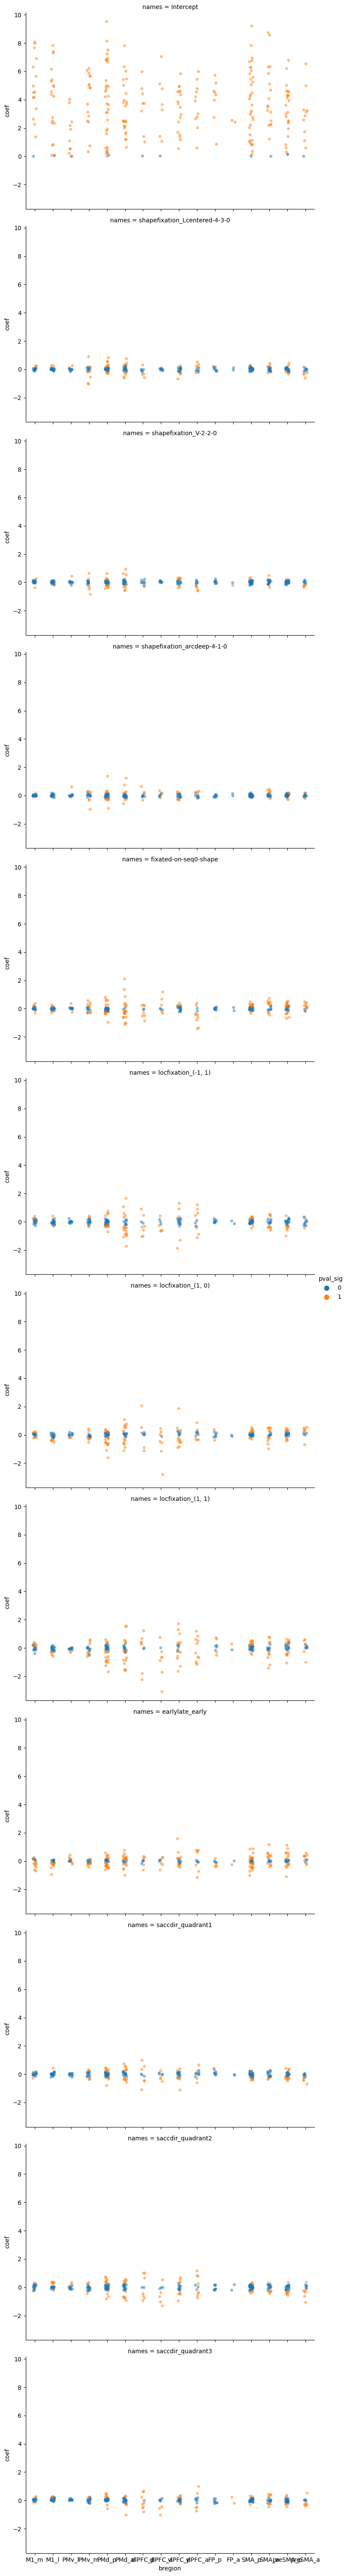

In [30]:
sns.catplot(data=lr_models, x='bregion', y='coef',row='names', hue='pval_sig', aspect=1.5, alpha=0.5)

In [53]:
from pythonlib.tools.snstools import rotateLabel

lr_models_nointer = lr_models[(lr_models['names']!='Intercept') & (lr_models['sm-fr-avg-events'] >=1)]
# glm_df_nointer = glm_df_new[(glm_df_new['sm-fr-avg-events'] >=1)]

fig = sns.catplot(data=lr_models_nointer, x='names', y='coef', col='bregion', col_wrap=4, hue='pval_sig', alpha=0.5)
rotateLabel(fig)
fig.show()

/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/seaborn/categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/seaborn/categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/seaborn/categorical.py:381: Depre

AttributeError: 'FacetGrid' object has no attribute 'show'

# MODEL 2

In [32]:
import pingouin as pg
import warnings
warnings.filterwarnings('default')

# for each channel, new regression model
d_vars = ['earlylate_early', 'shapefixation_Lcentered-4-3-0', 'shapefixation_V-2-2-0',
          'shapefixation_arcdeep-4-1-0', 'seen-this-shape-in-trial', 'prevshapefixation_Lcentered-4-3-0',
          'prevshapefixation_V-2-2-0', 'prevshapefixation_arcdeep-4-1-0',
          'fixated-on-seq0-shape', 'seqc0shape_Lcentered-4-3-0', 'seqc0shape_V-2-2-0',
          'seqc0shape_arcdeep-4-1-0',
         'locfixation_(-1, 1)', 'locfixation_(1, 0)', 'locfixation_(1, 1)',
         'saccdir_quadrant1', 'saccdir_quadrant2', 'saccdir_quadrant3'
         ]
# d_vars = ['fixated-on-seq0-shape', 'shapefixation_Lcentered-4-3-0', 'shapefixation_V-2-2-0',
#           'shapefixation_arcdeep-4-1-0', 'shapefixation_line-8-4-0', 'locfixation_(-1, 0)',
#           'locfixation_(-1, 1)', 'locfixation_(1, 0)', 'locfixation_(1, 1)', 'earlylate_quartile1',
#           'earlylate_quartile2', 'earlylate_quartile3', 'earlylate_quartile4',
#           'saccdir_quadrant1', 'saccdir_quadrant2', 'saccdir_quadrant3', 'saccdir_quadrant4']
chans = glm_df['chan'].unique()

# new plot for each dependent variable
results = []
frs = []
for c in chans:
    df_temp = glm_df[glm_df['chan']==c]
    #frs.append(np.mean(df_temp['avg-fr-sm-sqrt-post']))
    lr = pg.linear_regression(df_temp[d_vars],#df_temp[d_vars],
                         df_temp['avg-fr-sm-sqrt-post'])
    lr['chan'] = c
    lr['bregion'] = sn.sitegetterKS_map_site_to_region(c) # gets brain region from KS "site"
    lr['sm-fr-avg-events'] = np.mean(df_temp['avg-fr-sm-sqrt-post'])
    lr['sm-fr-std-events'] = np.std(df_temp['avg-fr-sm-sqrt-post'])
    results.append(lr)

lr_models = pd.concat(results).reset_index(drop=True)

lr_models['pval_sig'] = (lr_models['pval'] < 0.05)
lr_models['pval_sig'] = lr_models['pval_sig'].astype(int)

In [33]:
import seaborn as sns
#sns.relplot(data=lr_models, x='chan', y='coef',row='names', col='bregion', hue='pval_sig')

In [34]:
lr_models_nointer = lr_models[(lr_models['names']!='Intercept') & (lr_models['sm-fr-avg-events'] >=1)]
sns.catplot(data=lr_models_nointer, x='bregion', y='coef',row='names', hue='pval_sig', aspect=1.5, alpha=0.5)

/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/seaborn/categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/seaborn/categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/seaborn/categorical.py:381: Depre

In [35]:
from pythonlib.tools.snstools import rotateLabel

fig = sns.catplot(data=lr_models_nointer, x='names', y='coef', col='bregion', col_wrap=4, hue='pval_sig', alpha=0.5)
rotateLabel(fig)

/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/seaborn/categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/seaborn/categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/seaborn/categorical.py:381: Depre

# MODEL 3

In [36]:
import pingouin as pg
import warnings
warnings.filterwarnings('default')

# for each channel, new regression model
d_vars = ['earlylate_early', 'shapefixation_Lcentered-4-3-0', 'shapefixation_V-2-2-0',
          'shapefixation_arcdeep-4-1-0',
          'fixated-on-seq0-shape', 'seqc0shape_Lcentered-4-3-0', 'seqc0shape_V-2-2-0',
          'seqc0shape_arcdeep-4-1-0',
         'locfixation_(-1, 1)', 'locfixation_(1, 0)', 'locfixation_(1, 1)',
         'saccdir_quadrant1', 'saccdir_quadrant2', 'saccdir_quadrant3'
         ]
chans = glm_df['chan'].unique()

# new plot for each dependent variable
results = []
frs = []
for c in chans:
    df_temp = glm_df[glm_df['chan']==c]
    #frs.append(np.mean(df_temp['avg-fr-sm-sqrt-post']))
    lr = pg.linear_regression(df_temp[d_vars],#df_temp[d_vars],
                         df_temp['avg-fr-sm-sqrt-post'])
    lr['chan'] = c
    lr['bregion'] = sn.sitegetterKS_map_site_to_region(c) # gets brain region from KS "site"
    lr['sm-fr-avg-events'] = np.mean(df_temp['avg-fr-sm-sqrt-post'])
    lr['sm-fr-std-events'] = np.std(df_temp['avg-fr-sm-sqrt-post'])
    results.append(lr)

lr_models = pd.concat(results).reset_index(drop=True)

lr_models['pval_sig'] = (lr_models['pval'] < 0.05)
lr_models['pval_sig'] = lr_models['pval_sig'].astype(int)

In [37]:
import seaborn as sns
#sns.relplot(data=lr_models, x='chan', y='coef',row='names', col='bregion', hue='pval_sig')

In [38]:
lr_models_nointer = lr_models[(lr_models['names']!='Intercept') & (lr_models['sm-fr-avg-events'] >=1)]
sns.catplot(data=lr_models_nointer, x='bregion', y='coef',row='names', hue='pval_sig', aspect=1.5, alpha=0.5)

/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/seaborn/categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/seaborn/categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/seaborn/categorical.py:381: Depre

In [39]:
from pythonlib.tools.snstools import rotateLabel

lr_models_nointer = lr_models[(lr_models['names']!='Intercept') & (lr_models['sm-fr-avg-events'] >=1)]
# glm_df_nointer = glm_df_new[(glm_df_new['sm-fr-avg-events'] >=1)]

fig = sns.catplot(data=lr_models_nointer, x='names', y='coef', col='bregion', col_wrap=4, hue='pval_sig', alpha=0.5)
rotateLabel(fig)

/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/seaborn/categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/seaborn/categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/seaborn/categorical.py:381: Depre